<a href="https://colab.research.google.com/github/deboraeverlyab/code-challenge/blob/main/projeto3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Previsão de Conclusão de Curso

## Objetivo

O objetivo deste projeto é desenvolver um modelo preditivo que antecipe quais alunos irão concluir o curso no próximo semestre, com base no histórico acadêmico e situacional dos discentes. Essa previsão pode auxiliar a instituição a direcionar recursos e estratégias de acompanhamento para apoiar os alunos em risco ou próximos da conclusão.

## Dados Utilizados

Fonte: Portal de Dados Abertos / SIGAA – UFRN. Sem dados sensíveis: anonimização por matrícula.

Dados sobre:

- **Situações Acadêmicas**: Informações sobre o status do aluno em cada semestre, tais como *Cadastrado*, *Ativo*, *Trancado*, *Formando*, *Concluinte*, *Concluído*, *Cancelado* e *Excluído*.  
- **Dados de Matrículas**: Desempenho dos alunos em disciplinas ao longo dos semestres, incluindo notas finais, número de faltas, reposições, nível de ensino, entre outros.

## Definição do Problema

Trata-se de um problema de classificação binária, em que a variável alvo (`target`) indica se o aluno irá concluir o curso no próximo semestre. Para isso, considera-se que alunos com status “Formando”, “Concluinte” ou “Concluído” no semestre seguinte são os que concluíram (classe positiva = 1), e os demais como classe negativa (0).

## Modelos Utilizados

Para realizar a classificação, foram utilizados dois algoritmos supervisionados:

- **KNN (K-Nearest Neighbors)**: Classificador baseado na proximidade entre instâncias em um espaço de características, útil para capturar padrões locais nos dados.
- **Árvore de Decisão (Decision Tree)**: Algoritmo interpretável que cria regras hierárquicas com base nas variáveis de entrada, permitindo visualizar os caminhos que levam à conclusão ou não do curso.

Ambos os modelos foram treinados com variáveis como média das notas, número de faltas e quantidade de disciplinas cursadas por semestre.

## Benefícios Esperados

- Antecipação do momento de conclusão dos alunos.  
- Identificação precoce de alunos em risco de evasão ou trancamento.  
- Melhor planejamento acadêmico e administrativo.  
- Suporte personalizado aos estudantes.


#1. Importação dos dados

In [ ]:
# Instalações necessárias (execute uma vez por sessão)
!pip -q install pandas scikit-learn matplotlib seaborn gdown

# Bibliotecas padrão
from collections import Counter

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Modelagem
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Avaliação de modelos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Outros
import gdown

In [ ]:
# dados:
# Lista de URLs das situações
urls_situacoes = {
    "2018.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/11121608-0349-4206-87b3-f37058dea6df/download/situacoes-discentes-2018.1",
    "2018.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/05a42c06-daf3-4084-bd8d-fd3e0da48229/download/situacoes-discentes-2018.2",
    "2019.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/db557c8b-335f-40f0-bac0-0f17dbbd952b/download/situacoes-discentes-2019.1",
    "2019.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/33474973-c926-4a48-9679-417f24f77256/download/situacoes-discentes-2019.2",
    "2020.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/022de4d2-00b6-425c-be63-fe7f9c1fa9b3/download/situacoes-discentes-2020.1",
    "2020.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/e1bcfa89-01d0-4d18-b952-bd26f1448932/download/situacoes-discentes-2020.2",
    "2021.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/aec26783-705f-440f-afd8-14453bf5c7a0/download/situacoes-discentes-2021.1",
    "2021.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/20374c11-7215-4db5-9e3e-11458faaf7ce/download/situacoes-discentes-2021.2",
    "2022.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/1eb63126-532b-4642-9ee1-ac18ceca57b7/download/situacoes-discentes-2022.1",
    "2022.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/f4fd6545-755a-461c-8e14-b7d85096bf45/download/situacoes-discentes-2022.2",
    "2023.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/f67901a7-98e5-4624-aa4c-2dc858963a8d/download/situacoes-discentes-2023.1",
    "2023.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/324bd2d9-04c1-4418-ae87-ddf3c5a5e78f/download/situacoes-discentes-2023.2",
    "2024.1": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/e072185b-ed71-4bbe-88b9-85cac4ddecab/download/situacoes-discentes-2024.1",
    "2024.2": "https://dados.ufrn.br/dataset/8ff3a553-053a-4d02-aea5-42bdd73a180b/resource/817d6599-0f0a-4f03-b542-da03caa28973/download/situacoes-discentes-2024.2.csv",
}

# Lista de URLs das matrículas
urls_matriculas = {
    "2018.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/3c1feba4-ced1-466e-8e94-a040224a51dc/download/matricula-componente-20181.csv",
    "2018.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0bfcaf6a-4424-4983-8ba8-d330350a8fbe/download/matricula-componente-20182.csv",
    "2019.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/6d66d15a-8d0f-43a3-902b-d314f4a2a296/download/matricula-componente-20191.csv",
    "2019.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0d573a4f-de65-4c3d-b6bb-337473bc4e44/download/matricula-componente-20192.csv",
    "2020.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/4e4dd1fb-fc0b-460d-b52a-9f37a42b82b3/download/matricula-componente-20201.csv",
    "2020.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0748a131-f6ba-4b7c-b08d-3a69b8176a1b/download/matriculas-2020-2.csv",
    "2021.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/ffd73a99-325b-4835-9338-036be30fdec8/download/matriculas-2021-1.csv",
    "2021.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/d5a9b2ae-4bd7-4a43-b169-2f6a5c9d1379/download/matriculas-2021-2.csv",
    "2022.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/c3b45170-5417-4f2a-a53e-c8edbf6c501a/download/matriculas-2022.1.csv",
    "2022.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/b159805b-e7cb-4d71-872b-14a1a2625d7e/download/matriculas-2022.2.csv",
    "2023.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/e409fdb2-82a9-42ad-8491-92d3cf71033d/download/matriculas-2023.1.csv",
    "2023.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/5a3ff28a-0225-491b-9155-104aa60f09e0/download/matriculas-2023.2.csv",
    "2024.1": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/79d8a2ae-2e37-47d3-a44e-44f9fbd947ba/download/matriculas-2024.1.csv",
    "2024.2": "https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/0acc588e-7606-468a-9049-baff742879e1/download/matriculas-2024.2.csv",
}

**Curso escolhido: Engenharia Civil**

código = 2000025

In [ ]:
# carregando os dados

def carregar_dados(urls, tipo, id_curso=2000025, nivel_ensino="GRADUAÇÃO"):
    dfs = []
    for semestre, url in urls.items():
        try:
            df = pd.read_csv(url, sep=None, engine="python")

            if tipo == "matricula":
                df = df[df["id_curso"] == id_curso]

            elif tipo == "situacao":
                df = df[
                    (df["id_curso"] == id_curso) &
                    (df["nivel_ensino"].str.upper() == nivel_ensino.upper())
                ]

            df["semestre"] = semestre
            dfs.append(df)
            print(f"✅ {tipo.title()} {semestre} carregado com {len(df)} registros.")
        except Exception as e:
            print(f"❌ Erro ao carregar {tipo} {semestre}: {e}")

    return pd.concat(dfs, ignore_index=True)

# Carregar e salvar
df_situacoes = carregar_dados(urls_situacoes, "situacao")
df_situacoes.to_csv("situacoes_filtradas.csv", index=False)

df_matriculas = carregar_dados(urls_matriculas, "matricula")
df_matriculas.to_csv("matriculas_filtradas.csv", index=False)

✅ Situacao 2018.1 carregado com 693 registros.
✅ Situacao 2018.2 carregado com 584 registros.
✅ Situacao 2019.1 carregado com 625 registros.
✅ Situacao 2019.2 carregado com 594 registros.
✅ Situacao 2020.1 carregado com 596 registros.
✅ Situacao 2020.2 carregado com 558 registros.
✅ Situacao 2021.1 carregado com 564 registros.
✅ Situacao 2021.2 carregado com 580 registros.
✅ Situacao 2022.1 carregado com 623 registros.
✅ Situacao 2022.2 carregado com 671 registros.
✅ Situacao 2023.1 carregado com 712 registros.
✅ Situacao 2023.2 carregado com 588 registros.
✅ Situacao 2024.1 carregado com 564 registros.
✅ Situacao 2024.2 carregado com 515 registros.
✅ Matricula 2018.1 carregado com 10321 registros.
✅ Matricula 2018.2 carregado com 10004 registros.
✅ Matricula 2019.1 carregado com 9077 registros.
✅ Matricula 2019.2 carregado com 8964 registros.
✅ Matricula 2020.1 carregado com 13 registros.
✅ Matricula 2020.2 carregado com 8852 registros.
✅ Matricula 2021.1 carregado com 8549 registros.

#2. Tratamento dos dados

In [ ]:
# Verificando as colunas após carregar os dados

print("Cabeçalhos originais - Situações:")
print(df_situacoes.columns.tolist())

print("\nCabeçalhos originais - Matrículas:")
print(df_matriculas.columns.tolist())

Cabeçalhos originais - Situações:
['id_discente', 'ano_ingresso', 'periodo_ingresso', 'nivel_ensino', 'id_curso', 'curso', 'situacao', 'data_alteracao_situacao', 'ano_alteracao_situacao', 'periodo_alteracao_situacao', 'semestre']

Cabeçalhos originais - Matrículas:
['id_turma', 'discente', 'id_curso', 'unidade', 'nota', 'reposicao', 'faltas_unidade', 'media_final', 'numero_total_faltas', 'descricao', 'semestre']


### Filtragem das colunas relevantes

Nesta etapa, reduzimos os datasets para manter **apenas as colunas essenciais** ao nosso objetivo:  
**prever se um aluno irá concluir o curso no semestre seguinte**, com base no seu comportamento acadêmico.

---

#### 🟦 Dataset: `situacoes`

Removemos colunas como `ano_ingresso`, `periodo_ingresso`, `nivel_ensino`, `id_curso` e `data_alteracao_situacao` porque:

- Os dados já estão filtrados apenas para o curso de **Engenharia Civil** (`id_curso = 2000025`) com nível de ensino igual a Graduação, portanto a coluna `id_curso` e `nivel_ensino` se tornaram redundantes.
- As informações de ingresso e nível de ensino não são necessárias para a previsão baseada em comportamento recente.
- O foco da análise é acompanhar **a evolução da situação acadêmica ao longo dos semestres**, por isso mantivemos:

| Coluna         | Descrição                                                       |
|----------------|------------------------------------------------------------------|
| `id_discente`  | Identificador único do aluno                                    |
| `situacao`     | Situação do aluno naquele semestre (Ativo, Trancado, Formando…) |
| `semestre`     | Período ao qual a situação se refere (ex: 2021.2)               |

---

#### 🟨 Dataset: `matriculas`

Removemos colunas como `id_turma`, `id_curso`, `unidade`, `reposicao`, `faltas_unidade` porque:

- `id_curso` já foi filtrado previamente.
- `id_turma`, `unidade` e `reposicao` não agregam valor direto para análise de comportamento geral.
- `faltas_unidade` é substituída pela métrica agregada `numero_total_faltas`.

Mantivemos:

| Coluna                 | Descrição                                                            |
|------------------------|----------------------------------------------------------------------|
| `id_discente`          | Identificador do aluno                                               |
| `nota`                 | Nota da unidade                                                      |
| `media_final`          | Média final no componente (disciplina)                               |
| `numero_total_faltas`  | Total de faltas acumuladas no componente                             |
| `descricao`            | Resultado da matrícula (ex: Aprovado, Reprovado por Nota, etc.)      |
| `semestre`             | Período da matrícula (para alinhar com a situação no mesmo semestre) |

---

Esta filtragem torna o processo mais eficiente, reduz o ruído nos dados e nos permite focar na **extração de métricas comportamentais** e na **criação do rótulo-alvo** (`vai_concluir_no_proximo`) com maior clareza e interpretabilidade.


In [ ]:
# Selecionar colunas úteis
colunas_situacao = [
    'id_discente',
    'ano_ingresso', # Mantido
    'periodo_ingresso', # Mantido
    'nivel_ensino', # Mantido
    'id_curso', # Mantido
    'curso', # Mantido
    'situacao',
    'data_alteracao_situacao', # Mantido
    'ano_alteracao_situacao', # Mantido
    'periodo_alteracao_situacao', # Mantido
    'semestre'
]

colunas_matricula = [
    'discente',
    'nota',
    'media_final',
    'numero_total_faltas',
    'descricao',
    'semestre'
]

# Aplicar seleção
df_situacoes = df_situacoes[colunas_situacao]
df_matriculas = df_matriculas[colunas_matricula]

# Renomear para padronizar
df_matriculas = df_matriculas.rename(columns={'discente': 'id_discente'})

# 📌 Visualizar cabeçalhos finais
print("\nCabeçalhos após modificação - Situações:")
print(df_situacoes.columns.tolist())

print("\nCabeçalhos após modificação - Matrículas:")
print(df_matriculas.columns.tolist())


Cabeçalhos após modificação - Situações:
['id_discente', 'ano_ingresso', 'periodo_ingresso', 'nivel_ensino', 'id_curso', 'curso', 'situacao', 'data_alteracao_situacao', 'ano_alteracao_situacao', 'periodo_alteracao_situacao', 'semestre']

Cabeçalhos após modificação - Matrículas:
['id_discente', 'nota', 'media_final', 'numero_total_faltas', 'descricao', 'semestre']


❗**Verificacao do formato da media final**





In [ ]:
print(df_matriculas['media_final'].dropna().unique()[:50])

['0,0' '8,7' '8,6' '7,8' '7,5' '9,3' '8,2' '6,9' '8,4' '8,0' '7,7' '7,2'
 '6,2' '6,4' '5,7' '9,5' '8,3' '7,9' '7,0' '7,3' '9,0' '7,6' '8,8' '8,1'
 '7,4' '7,1' '9,7' '6,3' '5,8' '6,0' '5,0' '8,5' '4,6' '3,8' '6,5' '9,8'
 '9,9' '9,2' '9,6' '10,0' '2,9' '5,4' '1,4' '5,5' '6,8' '6,7' '5,9' '6,6'
 '6,1' '5,1']


❗**Conversao para formato ideal para o Pandas**


In [ ]:
df_matriculas['media_final'] = pd.to_numeric(
    df_matriculas['media_final'].astype(str).str.replace(',', '.', regex=False),
    errors='coerce'
)

df_matriculas['nota'] = pd.to_numeric(
    df_matriculas['nota'].astype(str).str.replace(',', '.', regex=False),
    errors='coerce'
)

print(df_matriculas['media_final'].dtype)
print(df_matriculas['media_final'].unique()[:50])

float64
[ nan  0.   8.7  8.6  7.8  7.5  9.3  8.2  6.9  8.4  8.   7.7  7.2  6.2
  6.4  5.7  9.5  8.3  7.9  7.   7.3  9.   7.6  8.8  8.1  7.4  7.1  9.7
  6.3  5.8  6.   5.   8.5  4.6  3.8  6.5  9.8  9.9  9.2  9.6 10.   2.9
  5.4  1.4  5.5  6.8  6.7  5.9  6.6  6.1]


In [ ]:
df_matriculas.groupby('semestre')['media_final'].apply(lambda x: x.notnull().sum()).sort_index()

,media_final
semestre,
2018.1,9483
2018.2,9299
2019.1,8381
2019.2,8222
2020.1,0
2020.2,8094
2021.1,7888
2021.2,7859
2022.1,7759


In [ ]:
print("Valores NÃO nulos - Situações:")
print(df_situacoes.notnull().sum())

print("\nValores NÃO nulos - Matrículas:")
print(df_matriculas.notnull().sum())

Valores NÃO nulos - Situações:
id_discente                   8467
ano_ingresso                  8467
periodo_ingresso              8467
nivel_ensino                  8467
id_curso                      8467
curso                         8467
situacao                      8467
data_alteracao_situacao       8467
ano_alteracao_situacao        8467
periodo_alteracao_situacao    8467
semestre                      8467
dtype: int64

Valores NÃO nulos - Matrículas:
id_discente            115382
nota                   106177
media_final            105738
numero_total_faltas    107601
descricao              115382
semestre               115382
dtype: int64


### Verificação de valores nulos

Antes de seguir para a extração de métricas e modelagem, realizamos uma análise da presença de valores ausentes nos dados.

#### 🟦 Dataset: `situações`

As colunas essenciais `id_discente`, `situacao` e `semestre` **não possuem valores nulos**:


#### 🟨 Dataset: `matriculas`

As colunas essenciais `id_discente`, `descricao` e `semestre` **não possuem valores nulos**:

In [ ]:
# Verifica valores nulos por coluna
print("Valores nulos - Situações:")
print(df_situacoes.isnull().sum())

print("\nValores nulos - Matrículas:")
print(df_matriculas.isnull().sum())

Valores nulos - Situações:
id_discente                   0
ano_ingresso                  0
periodo_ingresso              0
nivel_ensino                  0
id_curso                      0
curso                         0
situacao                      0
data_alteracao_situacao       0
ano_alteracao_situacao        0
periodo_alteracao_situacao    0
semestre                      0
dtype: int64

Valores nulos - Matrículas:
id_discente               0
nota                   9205
media_final            9644
numero_total_faltas    7781
descricao                 0
semestre                  0
dtype: int64


### Distribuição das Situações Acadêmicas por Semestre

O gráfico abaixo mostra como as situações acadêmicas dos alunos evoluem ao longo dos semestres.

Cada barra representa a quantidade de alunos em um determinado semestre, dividida por categoria de situação:

- **Cadastrado**: O indivíduo foi cadastrado no SIGAA, mas o período atual é anterior ao seu ingresso oficial. Aluno com matrícula inicial, sem vínculo ativo ainda.
- **Ativo**: O aluno possui vínculo ativo com a UFRN, está matriculado em seu curso e não está com status "Trancado" ou "Formando". Aluno regularmente matriculado.
- **Trancado**: O aluno solicitou e teve seu vínculo com a UFRN suspenso temporariamente. Matrícula suspensa temporariamente.
- **Formando**: O aluno está próximo de concluir o curso e pode solicitar a colação de grau. Aluno no final do curso, em processo de colação.
- **Concluinte**: O aluno já concluiu a carga horária mínima do curso, mas ainda não recebeu o grau acadêmico.
- **Concluído**: O aluno concluiu todas as pendências acadêmicas, recebeu o grau e teve o diploma registrado. Aluno que finalizou o curso.
- **Cancelado**: O vínculo do aluno com a UFRN foi encerrado devido a desistência, jubilamento ou outro motivo. Aluno desligado do curso.
- **Excluído**: O vínculo do aluno nunca deveria ter sido criado.

Essa visualização ajuda a identificar **tendências de conclusão ou evasão**, além de semestres com maior fluxo de formandos.


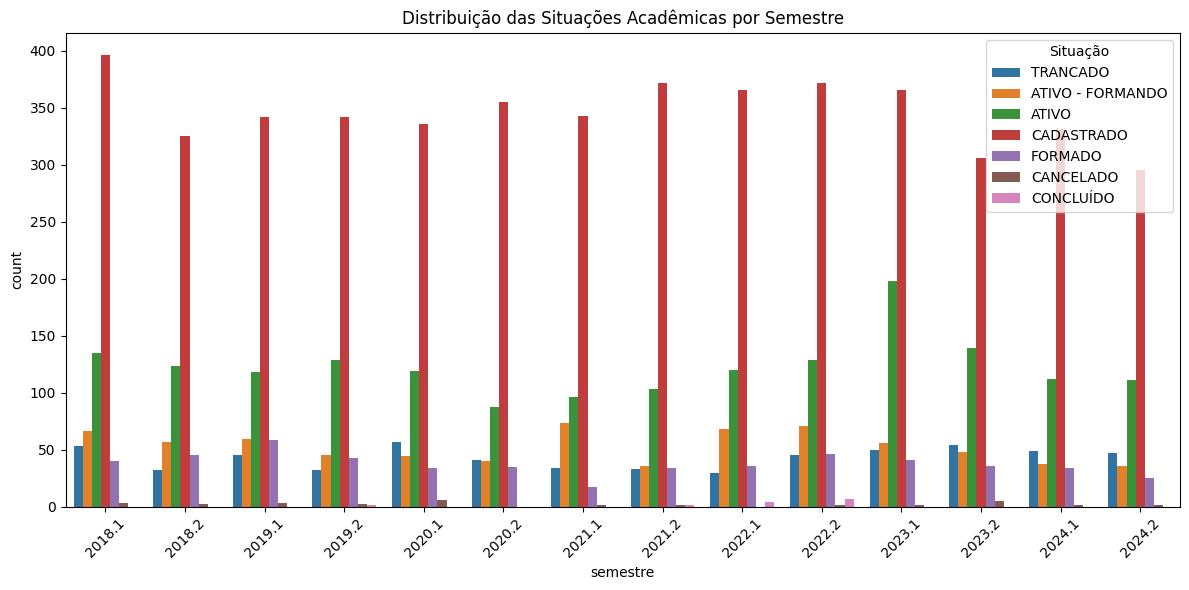

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_situacoes, x='semestre', hue='situacao', order=sorted(df_situacoes['semestre'].unique()))
plt.title("Distribuição das Situações Acadêmicas por Semestre")
plt.xticks(rotation=45)
plt.legend(title='Situação')
plt.tight_layout()
plt.show()

In [ ]:
# Exemplo de um discente por semestre:

df_matriculas[df_matriculas['id_discente'] == '001342e1641e65f2287f6e3566d84d3f'].sort_values('semestre')

,id_discente,nota,media_final,numero_total_faltas,descricao,semestre
39010,001342e1641e65f2287f6e3566d84d3f,4.9,5.4,12.0,APROVADO POR NOTA,2020.2
46944,001342e1641e65f2287f6e3566d84d3f,NaN,NaN,NaN,INDEFERIDO,2020.2
46839,001342e1641e65f2287f6e3566d84d3f,NaN,NaN,NaN,INDEFERIDO,2020.2
46753,001342e1641e65f2287f6e3566d84d3f,9.0,7.4,0.0,APROVADO,2020.2
46752,001342e1641e65f2287f6e3566d84d3f,6.7,7.4,0.0,APROVADO,2020.2
46751,001342e1641e65f2287f6e3566d84d3f,6.5,7.4,0.0,APROVADO,2020.2
42837,001342e1641e65f2287f6e3566d84d3f,4.9,5.4,0.0,APROVADO POR NOTA,2020.2
42836,001342e1641e65f2287f6e3566d84d3f,5.2,5.4,0.0,APROVADO POR NOTA,2020.2
41731,001342e1641e65f2287f6e3566d84d3f,9.0,9.0,0.0,APROVADO,2020.2
41730,001342e1641e65f2287f6e3566d84d3f,8.5,9.0,0.0,APROVADO,2020.2


In [ ]:
# Exemplo de situação do mesmo discente:

df_situacoes[df_situacoes['id_discente'] == '001342e1641e65f2287f6e3566d84d3f'].sort_values('semestre')

,id_discente,ano_ingresso,periodo_ingresso,nivel_ensino,id_curso,curso,situacao,data_alteracao_situacao,ano_alteracao_situacao,periodo_alteracao_situacao,semestre
2764,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.692000000,2020,1,2020.1
2765,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.748000000,2020,1,2020.1
2766,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.796000000,2020,1,2020.1
2767,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.843000000,2020,1,2020.1
2768,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.889000000,2020,1,2020.1
2769,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,CADASTRADO,2020/02/01 16:30:45.938000000,2020,1,2020.1
4721,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,ATIVO,2021/11/02 04:02:19.506000000,2021,2,2021.2
4802,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,ATIVO,2022/04/07 04:03:41.572000000,2022,1,2022.1
4832,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,TRANCADO,2022/03/07 11:45:29.508000000,2022,1,2022.1
5426,001342e1641e65f2287f6e3566d84d3f,2020,1,GRADUAÇÃO,2000025,ENGENHARIA CIVIL,TRANCADO,2022/08/02 08:12:41.282000000,2022,2,2022.2


### Destaque: Alunos Concluintes por Semestre

O gráfico abaixo mostra a evolução das situações acadêmicas ao longo do tempo, com **destaque para os alunos que estão nos status “Formando”, “Concluinte” ou “Concluído”** em cada semestre.

- As barras destacam a quantidade desses alunos em cada semestre, evidenciando os momentos com maior concentração de formaturas.  
- Essa visualização facilita análises sazonais, avaliação do impacto de eventos institucionais (como mudanças no currículo ou a pandemia) e o acompanhamento das tendências de conclusão.

Essa análise é fundamental para a criação do rótulo `vai_concluir_no_proximo`, pois ajuda a identificar o **padrão temporal de conclusão** dos alunos ao longo dos semestres.


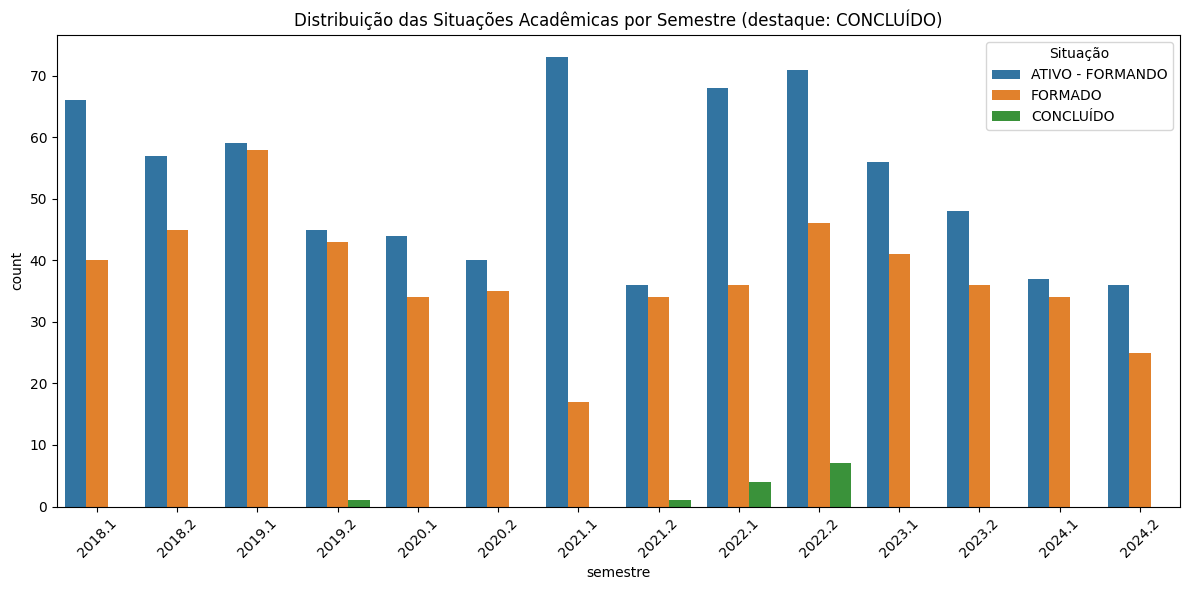

In [ ]:
# Filtra apenas situações relevantes (sem 'CADASTRADO')
df_filtrado = df_situacoes[~df_situacoes['situacao'].isin(['CADASTRADO', 'EXCLUIDO', 'TRANCADO', 'CANCELADO', 'ATIVO'])]

# Conta os concluintes por semestre
concluidos = df_filtrado[df_filtrado['situacao'] == 'CONCLUÍDO']
concluintes_por_semestre = concluidos['semestre'].value_counts().to_dict()

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_filtrado,
    x='semestre',
    hue='situacao',
    order=sorted(df_filtrado['semestre'].unique())
)

# Adiciona texto com a contagem de concluintes acima das barras
for p in ax.patches:
    categoria = p.get_hatch()
    altura = p.get_height()
    x = p.get_x() + p.get_width() / 2
    situacao = p.get_label()
    if p.get_facecolor() == sns.color_palette()[6]:  # rosa claro de 'CONCLUÍDO'
        semestre = p.get_x() + p.get_width() / 2
        label = p.get_label()
        plt.text(x, altura + 2, f'{int(altura)}', ha='center', fontsize=9, color='black')

plt.title("Distribuição das Situações Acadêmicas por Semestre (destaque: CONCLUÍDO)")
plt.xticks(rotation=45)
plt.legend(title='Situação')
plt.tight_layout()
plt.show()

### Criação da Variável Alvo

Para treinar um modelo de classificação supervisionada, é essencial criarmos uma variável alvo (target).
Neste projeto, queremos prever se um aluno irá concluir o curso no semestre seguinte ao que estamos analisando.

#### Lógica:
A criação da coluna **vai_concluir_no_proximo** se baseia na situação acadêmica do aluno no semestre seguinte.

1. Para cada aluno (id_discente) em um determinado semestre (semestre), buscamos qual foi sua situação acadêmica no semestre seguinte, utilizando uma função auxiliar que calcula o próximo semestre:

In [ ]:
def proximo_semestre(sem):
    ano, semestre = sem.split('.')
    ano = int(ano)
    semestre = int(semestre)
    if semestre == 1:
        return f"{ano}.2"
    else:
        return f"{ano + 1}.1"

# Criar coluna com o próximo semestre usando a função
df_situacoes['prox_semestre'] = df_situacoes['semestre'].apply(proximo_semestre)

2. A nova coluna **prox_semestre** é criada com base nessa função acima, e fazemos uma junção (merge) do DataFrame original com um novo DataFrame contendo as situações futuras dos alunos.

3. A partir da coluna **situacao_prox**, identificamos se o aluno encerrou ou estava finalizando o curso no semestre seguinte.

    Consideramos como sinais de conclusão as seguintes situações:

    "ATIVO - FORMANDO"

    "FORMADO"

    "CONCLUÍDO"

4. Com isso, criamos a variável binária **vai_concluir_no_proximo**:

    Valor 1: O aluno concluiu (ou estava em fase final de conclusão) no semestre seguinte.

    Valor 0: O aluno não concluiu o curso no semestre seguinte.

In [ ]:
# Preparar df com status do próximo semestre
df_prox = df_situacoes[['id_discente', 'semestre', 'situacao']].copy()
df_prox.rename(columns={'semestre': 'prox_semestre', 'situacao': 'situacao_prox'}, inplace=True)

# Juntar status futuro
df_merged = pd.merge(df_situacoes, df_prox, on=['id_discente', 'prox_semestre'], how='left')

# Criar os targets
status_conclusao = ['ATIVO - FORMANDO', 'FORMADO', 'CONCLUÍDO']

df_merged['vai_concluir_no_proximo'] = df_merged['situacao_prox'].isin(status_conclusao).astype(int)

vai_concluir_no_proximo → Se no próximo semestre o aluno estiver em uma das situações: ATIVO - FORMANDO, FORMADO ou CONCLUÍDO.

In [ ]:
# Garantir que os tipos estejam corretos
df_matriculas['media_final'] = pd.to_numeric(df_matriculas['media_final'], errors='coerce')
df_matriculas['numero_total_faltas'] = pd.to_numeric(df_matriculas['numero_total_faltas'], errors='coerce')

# Agregar por aluno e semestre
df_features = df_matriculas.groupby(['id_discente', 'semestre']).agg({
    'media_final': 'mean',
    'numero_total_faltas': 'sum',
    'descricao': 'count'  # Quantidade de disciplinas cursadas
}).reset_index()

# Renomear as colunas
df_features.rename(columns={
    'media_final': 'media_notas',
    'numero_total_faltas': 'faltas_totais',
    'descricao': 'qtd_disciplinas'
}, inplace=True)

# Juntar os dados de desempenho com os dados de situação+targets
df_modelo = pd.merge(
    df_merged,
    df_features,
    on=['id_discente', 'semestre'],
    how='left'
)

In [ ]:
# Preencher valores ausentes com a média das colunas de desempenho
df_modelo['media_notas'] = df_modelo['media_notas'].fillna(df_modelo['media_notas'].mean())
df_modelo['faltas_totais'] = df_modelo['faltas_totais'].fillna(df_modelo['faltas_totais'].mean())
df_modelo['qtd_disciplinas'] = df_modelo['qtd_disciplinas'].fillna(df_modelo['qtd_disciplinas'].mean())

In [ ]:
# Visualizar as colunas principais
print(df_modelo[['id_discente', 'semestre', 'situacao',
                 'vai_concluir_no_proximo', 'media_notas',
                 'faltas_totais', 'qtd_disciplinas']].head())

                        id_discente semestre  situacao  \
0  63662c866e95b04a7e960cfe41aa42b7   2018.1  TRANCADO   
1  5bc34ef40317166ab261e3b4a30d29f8   2018.1  TRANCADO   
2  5bc34ef40317166ab261e3b4a30d29f8   2018.1  TRANCADO   
3  6400ab1cdb5483526fcb188f32ab37b0   2018.1  TRANCADO   
4  7b9014a709b776d26c745ef2e4283d57   2018.1  TRANCADO   

   vai_concluir_no_proximo  media_notas  faltas_totais  qtd_disciplinas  
0                        0     4.125000     204.000000        12.000000  
1                        0     6.635485      89.938115        16.545162  
2                        0     6.635485      89.938115        16.545162  
3                        0     6.525000     180.000000        25.000000  
4                        0     6.635485      89.938115        16.545162  


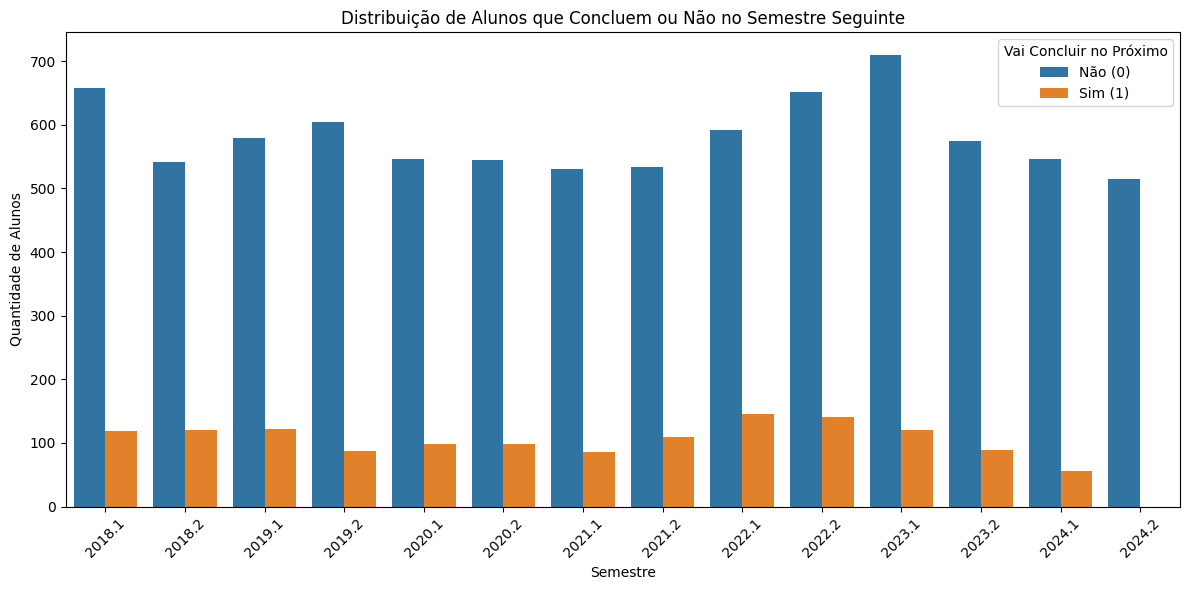

In [ ]:
# Gráfico da proporção de conclusão por semestre
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_modelo,
    x='semestre',
    hue='vai_concluir_no_proximo',
    order=sorted(df_modelo['semestre'].unique())
)
plt.title("Distribuição de Alunos que Concluem ou Não no Semestre Seguinte")
plt.xlabel("Semestre")
plt.ylabel("Quantidade de Alunos")
plt.legend(title="Vai Concluir no Próximo", labels=["Não (0)", "Sim (1)"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-860056317.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_modelo, x='vai_concluir_no_proximo', palette='pastel')


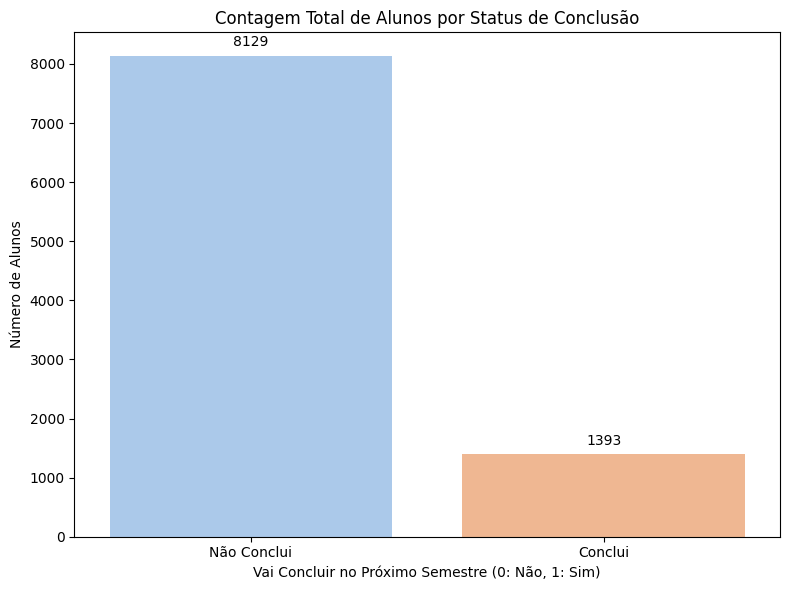

In [ ]:
# Gráfico da proporção de conclusão TOTAL
plt.figure(figsize=(8, 6))
sns.countplot(data=df_modelo, x='vai_concluir_no_proximo', palette='pastel')
plt.title("Contagem Total de Alunos por Status de Conclusão")
plt.xlabel("Vai Concluir no Próximo Semestre (0: Não, 1: Sim)")
plt.ylabel("Número de Alunos")
plt.xticks([0, 1], ['Não Conclui', 'Conclui']) # Renomear os ticks para clareza

# Adicionar os valores exatos nas barras (opcional)
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10),
                       textcoords='offset points')
plt.tight_layout()
plt.show()

In [ ]:
# Criar feature de razão faltas/disciplinas
df_modelo['razao_faltas_disciplinas'] = df_modelo['faltas_totais'] / (df_modelo['qtd_disciplinas'] + 1e-6) # Adiciona epsilon para evitar divisão por zero

In [ ]:
# Ver quantas linhas o df_modelo tem antes do drop
print(df_modelo.shape)

(9522, 18)


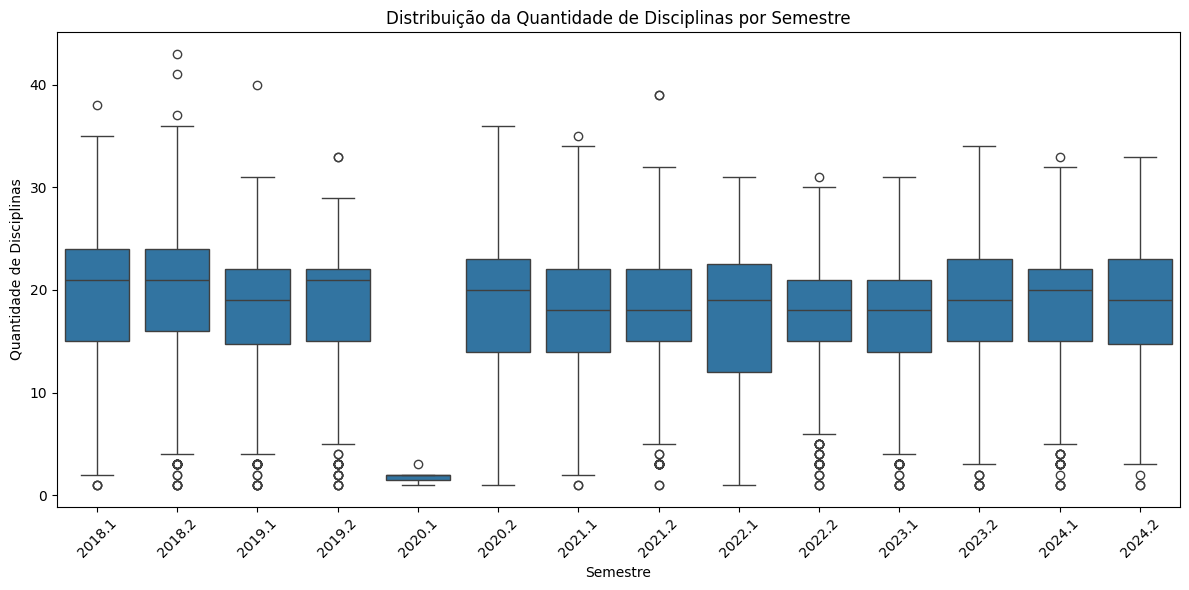

In [ ]:
# Este gráfico mostra a distribuição da quantidade de disciplinas cursadas pelos alunos em cada semestre.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features, x='semestre', y='qtd_disciplinas', order=sorted(df_features['semestre'].unique()))
plt.title("Distribuição da Quantidade de Disciplinas por Semestre")
plt.xlabel("Semestre")
plt.ylabel("Quantidade de Disciplinas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Distribuição da Quantidade de Disciplinas por Semestre**


Observa-se que a maioria dos semestres mantém uma mediana e um intervalo interquartil (caixa) relativamente estáveis em torno de 15 a 20 disciplinas, sugerindo uma carga de estudo consistente. No entanto, o semestre 2020.1 se destaca com uma mediana e variabilidade significativamente menores (próximas a 0-5 disciplinas), indicando um período atípico, provavelmente associado ao início da pandemia de COVID-19 e suas implicações no ensino, onde muitos alunos podem ter cursado menos disciplinas. As caudas dos boxplots (linhas verticais e pontos externos) mostram a presença de outliers, ou seja, alunos que se desviam dessa média, cursando um número excepcionalmente alto ou baixo de disciplinas em determinados semestres.

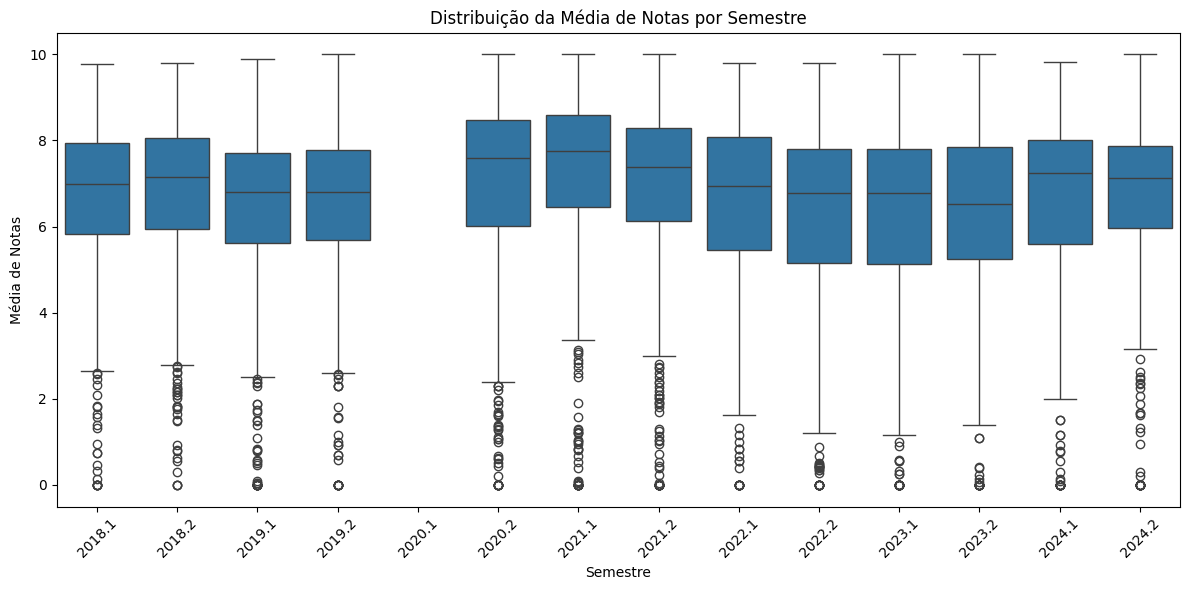

In [ ]:
# Este gráfico exibe a distribuição das médias de notas dos alunos em cada semestre.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features, x='semestre', y='media_notas', order=sorted(df_features['semestre'].unique()))
plt.title("Distribuição da Média de Notas por Semestre")
plt.xlabel("Semestre")
plt.ylabel("Média de Notas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Distribuição da Média de Notas por Semestre**

A maioria dos semestres exibe medianas de notas concentradas na faixa de 6 a 8, indicando um desempenho geral satisfatório e estável ao longo do curso. O período 2020.1 também se diferencia aqui, apresentando uma mediana de notas um pouco mais baixa e maior dispersão, o que pode ser outro reflexo dos desafios impostos pela pandemia. A presença de múltiplos outliers (círculos abaixo das caixas) em todos os semestres, com notas muito baixas (próximas de 0), sugere que, em todos os períodos, uma parcela de alunos teve desempenho acadêmico significativamente abaixo da média. A estabilidade das medianas e quartis na maioria dos semestres, exceto no atípico 2020.1, sugere que o padrão de desempenho geral da turma se manteve consistente.

/tmp/ipython-input-26-3919486353.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_modelo, x='vai_concluir_no_proximo', y='faltas_totais', palette='viridis')


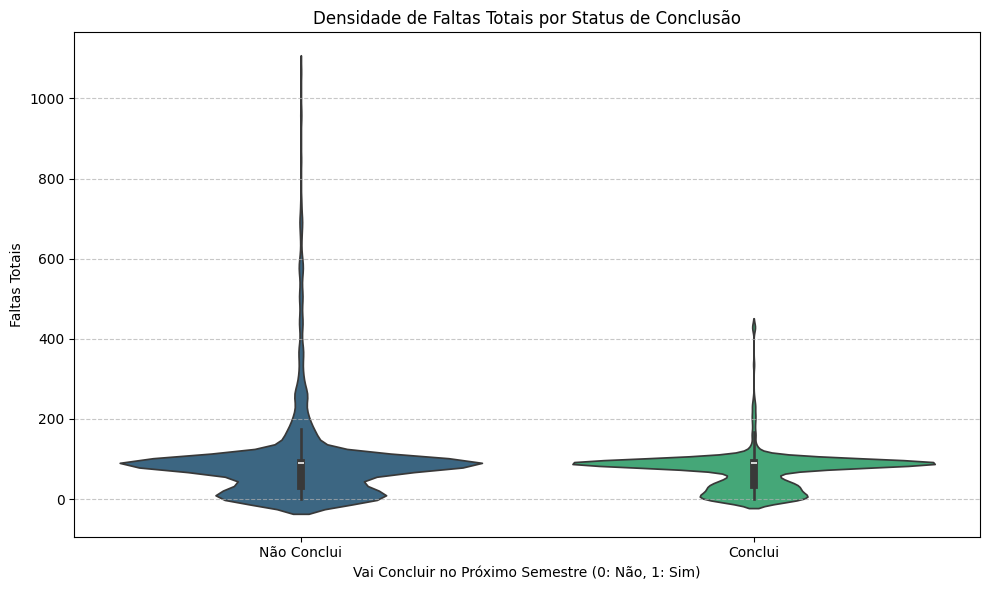

In [ ]:
# Este gráfico exibe a distribuição da densidade de faltas totais.

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_modelo, x='vai_concluir_no_proximo', y='faltas_totais', palette='viridis')
plt.title("Densidade de Faltas Totais por Status de Conclusão")
plt.xlabel("Vai Concluir no Próximo Semestre (0: Não, 1: Sim)")
plt.ylabel("Faltas Totais")
plt.xticks([0, 1], ['Não Conclui', 'Conclui'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

O formato do violino para a categoria "Não Conclui" (à esquerda) é muito mais "espremido" na parte inferior e depois se alarga significativamente com uma cauda longa para cima.

- Isso indica que a grande maioria dos alunos que não concluem têm um número muito baixo de faltas totais, concentrando-se perto de zero.

- No entanto, a cauda longa para cima (a "ponta" mais alta do violino) mostra que há uma proporção considerável de alunos que não concluem e que, ao mesmo tempo, acumulam um número extremamente alto de faltas, chegando a mais de 1000 faltas. Isso sugere que alunos com faltas muito elevadas quase certamente não concluem, mas a maioria que não conclui tem poucas faltas.


O violino para a categoria "Conclui" (à direita) é mais simétrico e menos "esticado" verticalmente, embora ainda com uma concentração forte em valores baixos.

- A densidade principal (a parte mais larga do violino) está também próxima de zero faltas. Isso é esperado, pois para concluir, o aluno geralmente precisa ter um bom comparecimento.

- A cauda superior do violino é muito mais curta e menos densa em comparação com a categoria "Não Conclui", indicando que é raro que alunos que concluem acumulem um número muito elevado de faltas. Existem alguns, mas a proporção é bem menor.


Concluindo:

- ter poucas faltas é comum para ambos os grupos.
- A principal diferença é a presença de um subgrupo significativo de alunos com faltas extremamente altas apenas na categoria "Não Conclui". Esse grupo de alta falta é um forte indicativo de não conclusão.

# 3. Aplicação do Modelo

Agora que extraímos as features de desempenho (`media_notas`, `faltas_totais`, `qtd_disciplinas`, `razao_faltas_disciplinas`) e criamos a variável alvo (`vai_concluir_no_proximo`), podemos separar os dados e alimentar os modelos de aprendizado de máquina.

### Seleção de Features e Target e Divisão em Treino/Teste

Vamos selecionar as features que usaremos para prever a conclusão do curso e a variável alvo. Em seguida, dividiremos o dataset em conjuntos de treino e teste para avaliar o desempenho do modelo de forma justa.

In [ ]:
# Definir features (X) e target (y)
features = ['media_notas', 'faltas_totais', 'qtd_disciplinas', 'razao_faltas_disciplinas']
target = 'vai_concluir_no_proximo'

X = df_modelo[features]
y = df_modelo[target]

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (7617, 4)
Shape de X_test: (1905, 4)
Shape de y_train: (7617,)
Shape de y_test: (1905,)


Para melhorar o desempenho dos modelos, vamos otimizar seus hiperparâmetros utilizando o GridSearchCV. Essa técnica busca exaustivamente por meio de um espaço de parâmetros definido para encontrar a melhor combinação que maximize uma métrica de avaliação (neste caso, usaremos o F1-score, que é útil em problemas com classes desbalanceadas).

Utilizaremos validação cruzada (StratifiedKFold) para garantir que a avaliação seja robusta e que a proporção das classes seja mantida em cada fold, o que é importante para o nosso dataset.

### Modelo 1: K-Nearest Neighbors (KNN)

O KNN é um algoritmo simples que classifica um ponto de dados com base na maioria das classes de seus "k" vizinhos mais próximos no espaço de features.

Para determinar o valor ideal de k no nosso modelo KNN, utilizamos o **GridSearchCV com validação cruzada estratificada de 5 folds**, testando valores de k de 1 a 12. Esta abordagem sistemática nos permitiu encontrar o k que otimiza o F1-score ponderado, uma métrica mais robusta que a acurácia para nosso dataset desbalanceado. O resultado indicou que **k=5** foi o melhor valor, proporcionando um **F1-score de 0.8689** na fase de validação, e um desempenho no conjunto de teste com 89% de acurácia, demonstrando que, das previsões de "concluir", 76% estavam corretas, e 35% de todos os concluintes foram identificados pelo modelo.

In [ ]:
# 1. Criar um Pipeline:
# O pipeline garante que o escalonamento seja feito corretamente em cada fold da validação cruzada.
# Primeiro, o StandardScaler escala os dados, e depois o KNeighborsClassifier é aplicado.
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de escalonamento
    ('knn', KNeighborsClassifier()) # Etapa do modelo KNN
])

# 2. Definir o range de valores de 'k' para testar:
param_grid = {
    'knn__n_neighbors': range(1, 13, 1)
}

# 3. Escolher a Métrica de Avaliação:
from sklearn.metrics import f1_score, make_scorer
scoring_metric = make_scorer(f1_score, average='weighted')

# 4. Configurar o GridSearchCV:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 5 folds, embaralha os dados
    scoring=scoring_metric,
    n_jobs=-1, # Usa todos os cores da CPU
    verbose=1 # Mostra o progresso
)

# 5. Executar a busca em grade nos dados de treino:
print("Iniciando a busca em grade para o melhor 'k'...")
grid_search.fit(X_train, y_train)

# 6. Obter os Melhores Resultados:
print("\n--- Resultados da Busca em Grade ---")
print(f"Melhor valor de k encontrado: {grid_search.best_params_['knn__n_neighbors']}")
print(f"Melhor F1-score (treino com validação cruzada): {grid_search.best_score_:.4f}")

# 7. Avaliar o Modelo Final com o Melhor k no Conjunto de Teste:
best_knn_model = grid_search.best_estimator_
y_pred_best_knn = best_knn_model.predict(X_test)


print("\n--- Avaliação do Modelo KNN com o Melhor 'k' (no conjunto de teste) ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best_knn))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best_knn))

Iniciando a busca em grade para o melhor 'k'...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Resultados da Busca em Grade ---
Melhor valor de k encontrado: 5
Melhor F1-score (treino com validação cruzada): 0.8689

--- Avaliação do Modelo KNN com o Melhor 'k' (no conjunto de teste) ---
Matriz de Confusão:
[[1596   30]
 [ 182   97]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1626
           1       0.76      0.35      0.48       279

    accuracy                           0.89      1905
   macro avg       0.83      0.66      0.71      1905
weighted avg       0.88      0.89      0.87      1905



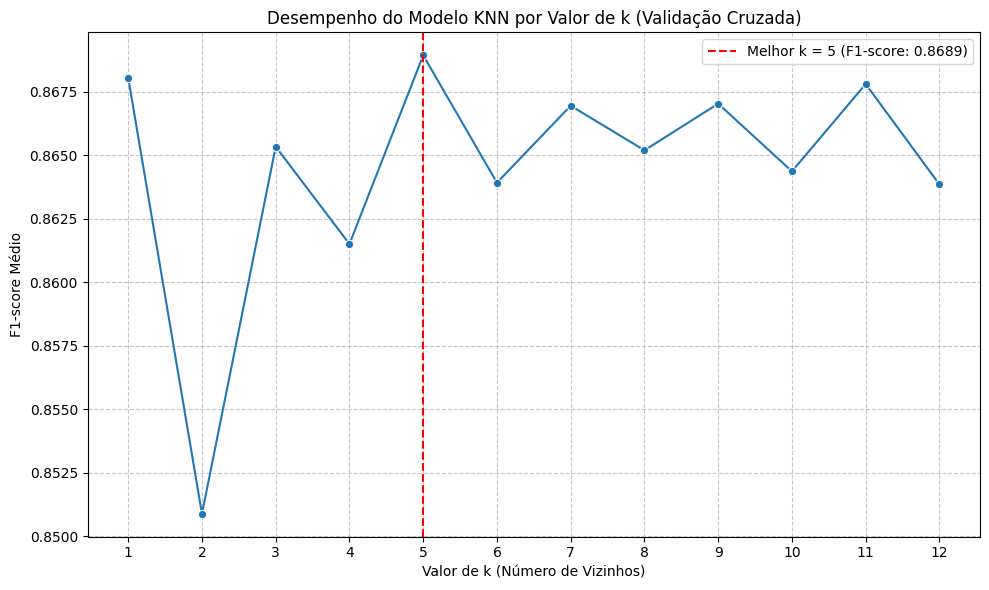

In [ ]:
results = grid_search.cv_results_

# Crie um DataFrame para facilitar a visualização
df_results = pd.DataFrame(results)

# Selecione as colunas relevantes: o valor de k e a média do score de teste
plot_data = df_results[['param_knn__n_neighbors', 'mean_test_score']]

plot_data.columns = ['Valor de k', 'F1-score Médio (Validação Cruzada)']

# Plotar o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Valor de k', y='F1-score Médio (Validação Cruzada)', marker='o')

# Adicione uma linha vertical para destacar o melhor k
best_k = grid_search.best_params_['knn__n_neighbors']
best_score = grid_search.best_score_
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Melhor k = {best_k} (F1-score: {best_score:.4f})')

plt.title('Desempenho do Modelo KNN por Valor de k (Validação Cruzada)')
plt.xlabel('Valor de k (Número de Vizinhos)')
plt.ylabel('F1-score Médio')
plt.xticks(plot_data['Valor de k'].unique()) # Garante que todos os k's testados apareçam no eixo x
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 1. pipeline com k=5
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5)) # K agora é fixo em 5
])
# 2. Treine o modelo usando o pipeline nos dados de treino
print(f"Treinando o modelo KNN com k={pipeline_knn.named_steps['knn'].n_neighbors}...")
pipeline_knn.fit(X_train, y_train)

# 3. Faça previsões no conjunto de teste
y_pred_knn = pipeline_knn.predict(X_test)

# 4. Avalie o desempenho do modelo
print("\n--- Avaliação do Modelo KNN com k=5 (no conjunto de teste) ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_knn))

Treinando o modelo KNN com k=5...

--- Avaliação do Modelo KNN com k=5 (no conjunto de teste) ---
Matriz de Confusão:
[[1596   30]
 [ 182   97]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1626
           1       0.76      0.35      0.48       279

    accuracy                           0.89      1905
   macro avg       0.83      0.66      0.71      1905
weighted avg       0.88      0.89      0.87      1905



### Modelo 2: Árvore de Decisão (Decision Tree)

A Árvore de Decisão é um modelo que cria uma estrutura de árvore onde cada nó interno representa um teste em um atributo, cada ramo representa o resultado do teste e cada nó folha representa uma decisão de classe.

Para ter um modelo de Árvore de Decisão otimizado, empregamos o GridSearchCV com validação cruzada estratificada de 5 folds, explorando uma vasta gama de hiperparâmetros, incluindo max_depth, min_samples_split, min_samples_leaf e criterion. Após testar 192 combinações em um total de 960 fits, os melhores parâmetros encontrados foram criterion='gini', max_depth=7, min_samples_leaf=1 e **min_samples_split**=2, resultando em um F1-score ponderado de 0.8762 na validação cruzada. Na avaliação final com o conjunto de teste, o modelo otimizado obteve uma acurácia de 89%, com uma matriz de confusão indicando 1589 verdadeiros negativos e 106 verdadeiros positivos, e um F1-score de 0.50 para a classe de alunos concluintes.

Iniciando a busca em grade para os melhores hiperparâmetros da Árvore de Decisão...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

--- Resultados da Busca em Grade para Árvore de Decisão ---
Melhores parâmetros encontrados: {'dt__criterion': 'gini', 'dt__max_depth': 7, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Melhor F1-score (treino com validação cruzada): 0.8762

--- Avaliação do Modelo de Árvore de Decisão com Melhores Parâmetros (no conjunto de teste) ---
Matriz de Confusão:
[[1589   37]
 [ 173  106]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1626
           1       0.74      0.38      0.50       279

    accuracy                           0.89      1905
   macro avg       0.82      0.68      0.72      1905
weighted avg       0.88      0.89      0.87      1905



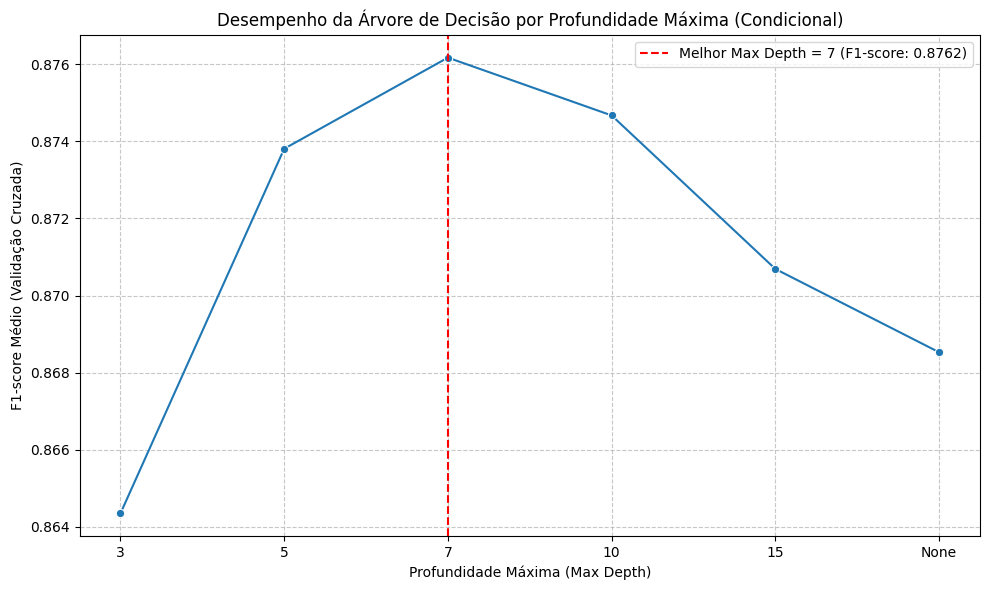

In [ ]:
pipeline_dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42)) # random_state para reprodutibilidade
])

# 2. Defina o range de hiperparâmetros para testar:
param_grid_dt = {
    'dt__max_depth': [3, 5, 7, 10, 15, None], # None significa profundidade total
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__criterion': ['gini', 'entropy']
}

# 3. Escolha a Métrica de Avaliação:
scoring_metric_dt = make_scorer(f1_score, average='weighted')

# 4. Configure o GridSearchCV para a Árvore de Decisão:
grid_search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring_metric_dt,
    n_jobs=-1, # Usa todos os cores da CPU para acelerar
    verbose=1 # Mostra o progresso
)

# 5. Execute a busca em grade nos dados de treino:
print("Iniciando a busca em grade para os melhores hiperparâmetros da Árvore de Decisão...")
grid_search_dt.fit(X_train, y_train)

# 6. Obtenha os Melhores Resultados:
print("\n--- Resultados da Busca em Grade para Árvore de Decisão ---")
print(f"Melhores parâmetros encontrados: {grid_search_dt.best_params_}")
print(f"Melhor F1-score (treino com validação cruzada): {grid_search_dt.best_score_:.4f}")

# 7. Avalie o Modelo Final com os Melhores Parâmetros no Conjunto de Teste:
best_dt_model = grid_search_dt.best_estimator_
y_pred_best_dt = best_dt_model.predict(X_test)

print("\n--- Avaliação do Modelo de Árvore de Decisão com Melhores Parâmetros (no conjunto de teste) ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best_dt))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best_dt))

# Extrair os resultados do GridSearchCV
df_results_dt = pd.DataFrame(grid_search_dt.cv_results_)

# Filtre os resultados para um 'criterion' específico e valores típicos para min_samples_split/leaf
best_criterion = grid_search_dt.best_params_['dt__criterion']
best_min_samples_split = grid_search_dt.best_params_['dt__min_samples_split']
best_min_samples_leaf = grid_search_dt.best_params_['dt__min_samples_leaf']

filtered_results_dt = df_results_dt[
    (df_results_dt['param_dt__criterion'] == best_criterion) &
    (df_results_dt['param_dt__min_samples_split'] == best_min_samples_split) &
    (df_results_dt['param_dt__min_samples_leaf'] == best_min_samples_leaf)
].copy()

# Crie uma nova coluna para o valor de max_depth para o gráfico
filtered_results_dt['Max Depth Plot'] = filtered_results_dt['param_dt__max_depth'].apply(
    lambda x: np.inf if x is None else x
)

# Ordene os resultados pelo valor numérico para que o plot fique correto
filtered_results_dt = filtered_results_dt.sort_values(by='Max Depth Plot')

# Prepare os labels do eixo X para incluir 'None' como texto onde for np.inf
x_labels = [str(int(val)) if val != np.inf else 'None' for val in filtered_results_dt['Max Depth Plot']]
x_positions = np.arange(len(x_labels)) # Posições para o plot

# Você precisa definir a figura e depois chamar o sns.lineplot com as posições numéricas
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_positions, y=filtered_results_dt['mean_test_score'], marker='o')

# Defina os ticks e labels do eixo X DEPOIS de chamar sns.lineplot
plt.xticks(x_positions, x_labels)

# Adicione uma linha vertical para destacar o melhor max_depth encontrado
best_max_depth_val = grid_search_dt.best_params_['dt__max_depth']
if best_max_depth_val is None:
    best_k_plot_pos = np.where(filtered_results_dt['Max Depth Plot'] == np.inf)[0][0]
    plt.axvline(x=best_k_plot_pos, color='r', linestyle='--', label=f'Melhor Max Depth = None (F1-score: {grid_search_dt.best_score_:.4f})')
else:
    best_k_plot_pos = np.where(filtered_results_dt['Max Depth Plot'] == best_max_depth_val)[0][0]
    plt.axvline(x=best_k_plot_pos, color='r', linestyle='--', label=f'Melhor Max Depth = {best_max_depth_val} (F1-score: {grid_search_dt.best_score_:.4f})')

plt.title('Desempenho da Árvore de Decisão por Profundidade Máxima (Condicional)')
plt.xlabel('Profundidade Máxima (Max Depth)')
plt.ylabel('F1-score Médio (Validação Cruzada)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Melhores parâmetros encontrados pelo GridSearchCV para a Árvore de Decisão:
best_dt_params = {
    'criterion': 'gini',
    'max_depth': 7,
    'min_samples_leaf': 1,
    'min_samples_split': 2
}

# 1. Pipeline para a Árvore de Decisão com os melhores parâmetros
pipeline_dt_final = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42, **best_dt_params))
])

# 2. Treine o modelo usando o pipeline nos dados de treino
print("Treinando o modelo de Árvore de Decisão com os parâmetros otimizados...")
pipeline_dt_final.fit(X_train, y_train)

# 3. Faça previsões no conjunto de teste
y_pred_dt_final = pipeline_dt_final.predict(X_test)

# 4. Avalie o desempenho do modelo final
print("\n--- Avaliação do Modelo de Árvore de Decisão (Final) no Conjunto de Teste ---")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_dt_final))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_dt_final))

Treinando o modelo de Árvore de Decisão com os parâmetros otimizados...

--- Avaliação do Modelo de Árvore de Decisão (Final) no Conjunto de Teste ---
Matriz de Confusão:
[[1589   37]
 [ 173  106]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1626
           1       0.74      0.38      0.50       279

    accuracy                           0.89      1905
   macro avg       0.82      0.68      0.72      1905
weighted avg       0.88      0.89      0.87      1905



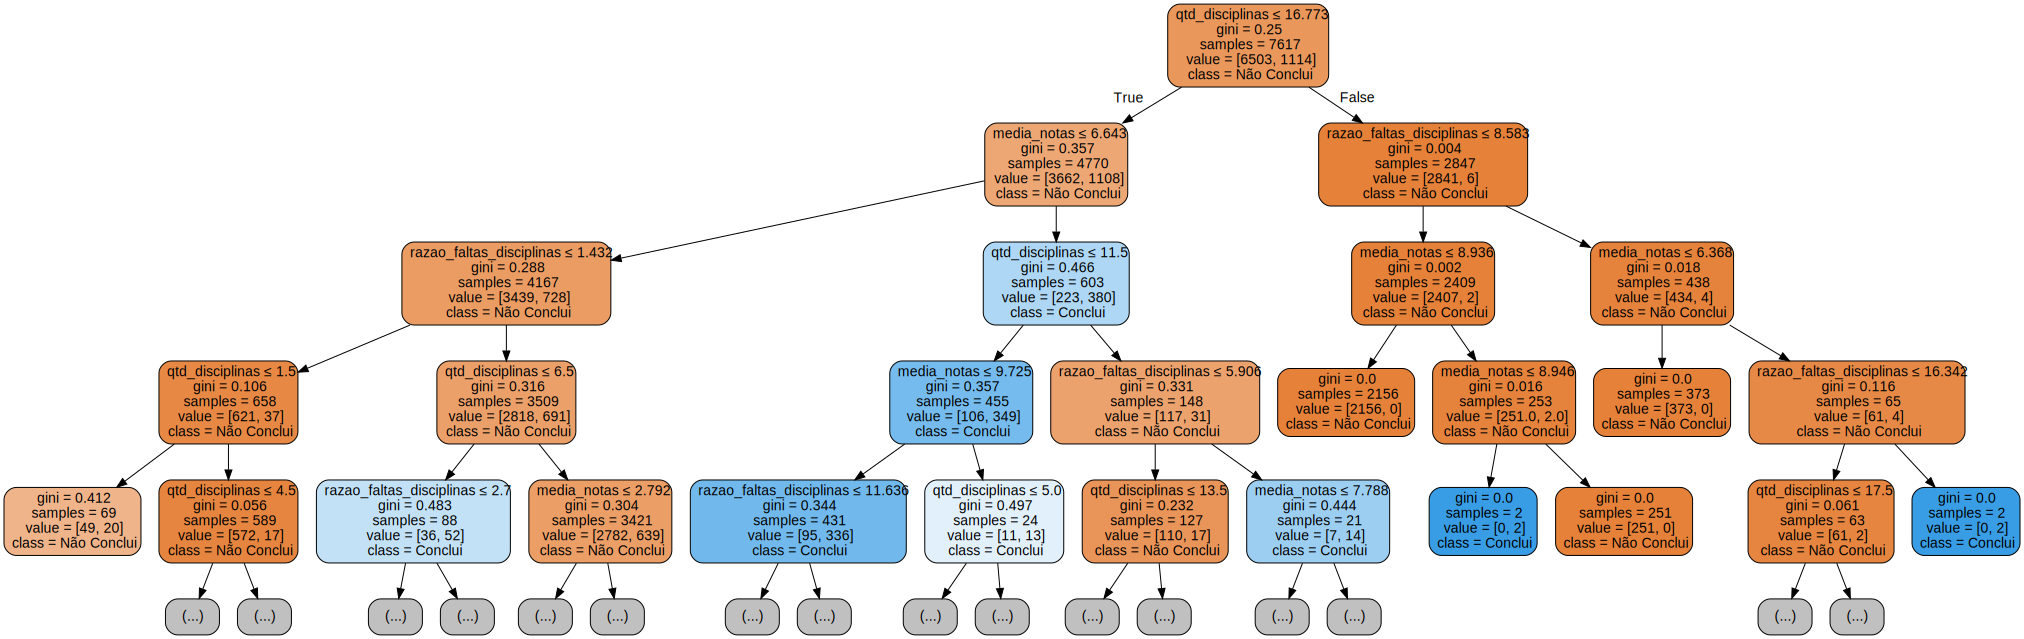

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Acesse o modelo DecisionTreeClassifier dentro do pipeline
dt_model = pipeline_dt_final.named_steps['dt']

# Assumindo que 0 = 'Não Conclui' e 1 = 'Conclui'
class_names = ['Não Conclui', 'Conclui']

dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=features,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=4              # Limitar a profundidade para visualização
)

# Renderizar o gráfico usando graphviz
graph = graphviz.Source(dot_data)

graph

### O que podemos concluir com a árvore de decisão:

1. Importância das Features: A qtd_disciplinas, media_notas e razao_faltas_disciplinas são as variáveis mais influentes. Elas aparecem repetidamente como critérios de divisão em diferentes níveis da árvore.

2. Primeiras Decisões: O nó raiz, qtd_disciplinas <= 16.713, estabelece a primeira grande segmentação dos dados. Essa é a decisão mais impactante do modelo.

3. Caminhos de Previsão: Nós laranja/marrom indicam a classe "Não Conclui", enquanto nós azuis representam "Conclui". A maioria dos caminhos termina em "Não Conclui", refletindo o desbalanço de classes.

# Comparando o Desempenho dos Modelos: KNN vs. Árvore de Decisão

Ao final do processo de otimização e avaliação, pudemos comparar o desempenho do nosso modelo KNN (K-Nearest Neighbors) e da Árvore de Decisão usando as métricas chave no conjunto de teste. Ambos os modelos apresentaram uma performance robusta, com a Acurácia Geral sendo praticamente idêntica:
- 0.8887 para o KNN
- 0.8898 para a Árvore de Decisão.

Isso indica que ambos são eficientes em classificar corretamente a grande maioria dos alunos.

No entanto, a verdadeira distinção entre os modelos surge ao analisarmos as métricas focadas na classe minoritária, os "Concluintes". O KNN demonstrou uma Precision de 0.7638, superando a Árvore de Decisão (0.7413).

Isso significa que, quando o KNN prevê que um aluno vai concluir, ele é ligeiramente mais preciso em sua afirmação, gerando menos "falsos alarmes" de conclusão.

Por outro lado, a Árvore de Decisão exibiu um Recall superior (0.3799) em comparação com o KNN (0.3477).

Essa métrica revela que a Árvore de Decisão consegue identificar uma proporção maior dos alunos que realmente concluem o curso, sendo um pouco mais eficaz em "capturar" esses casos importantes.


Consequentemente, o F1-score para Concluintes reflete essas diferenças, sendo marginalmente maior na Árvore de Decisão (0.5024) do que no KNN (0.4778).

Embora a Árvore de Decisão mostre uma leve vantagem no equilíbrio entre Precision e Recall para a classe positiva, é crucial notar que ambos os modelos ainda enfrentam um desafio significativo no Recall, indicando que uma parcela considerável dos alunos que concluem não está sendo detectada.


### Avaliação do Modelo Árvore de Decisão

De forma similar, analisamos as métricas para o modelo de Árvore de Decisão.

*(Incluir aqui a interpretação numérica dos resultados da Árvore de Decisão a partir do output do cell `20f84fac`)*

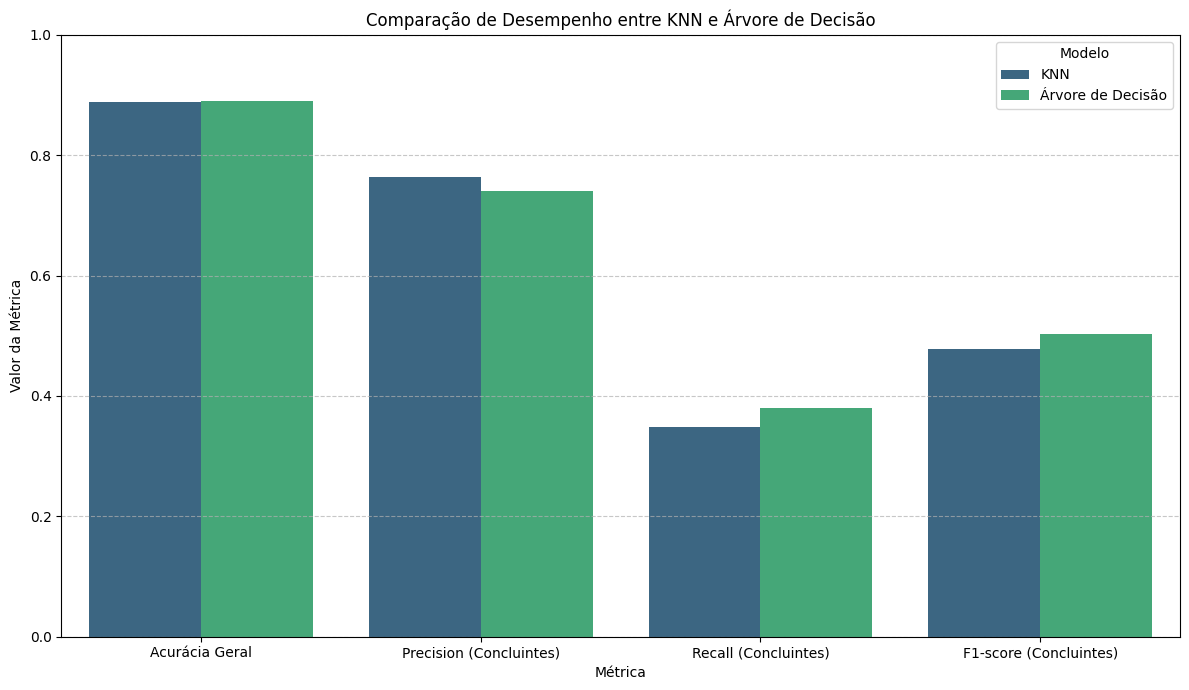


--- Resumo das Métricas Chave ---
                              KNN  Árvore de Decisão
Métrica                                             
Acurácia Geral           0.888714           0.889764
Precision (Concluintes)  0.763780           0.741259
Recall (Concluintes)     0.347670           0.379928
F1-score (Concluintes)   0.477833           0.502370


In [ ]:
# Coletar os resultados dos modelos
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt_final, output_dict=True)

# Extrair métricas relevantes para a comparação
accuracy_knn = report_knn['accuracy']
precision_knn = report_knn['1']['precision']
recall_knn = report_knn['1']['recall']
f1_score_knn = report_knn['1']['f1-score']

accuracy_dt = report_dt['accuracy']
precision_dt = report_dt['1']['precision']
recall_dt = report_dt['1']['recall']
f1_score_dt = report_dt['1']['f1-score']

# Criar um DataFrame para facilitar a plotagem com Seaborn
data = {
    'Métrica': ['Acurácia Geral', 'Precision (Concluintes)', 'Recall (Concluintes)', 'F1-score (Concluintes)'],
    'KNN': [accuracy_knn, precision_knn, recall_knn, f1_score_knn],
    'Árvore de Decisão': [accuracy_dt, precision_dt, recall_dt, f1_score_dt]
}
df_comparison = pd.DataFrame(data)

# Converter o DataFrame para o formato "long" para o Seaborn
df_comparison_melted = df_comparison.melt(id_vars='Métrica', var_name='Modelo', value_name='Valor')

# Plotar os gráficos de barras
plt.figure(figsize=(12, 7))
sns.barplot(data=df_comparison_melted, x='Métrica', y='Valor', hue='Modelo', palette='viridis')

plt.title('Comparação de Desempenho entre KNN e Árvore de Decisão')
plt.ylabel('Valor da Métrica')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

print("\n--- Resumo das Métricas Chave ---")
print(df_comparison.set_index('Métrica'))

# Visualização dos Resultados

Para complementar a análise, vamos visualizar graficamente alguns resultados importantes, incluindo as matrizes de confusão dos modelos.

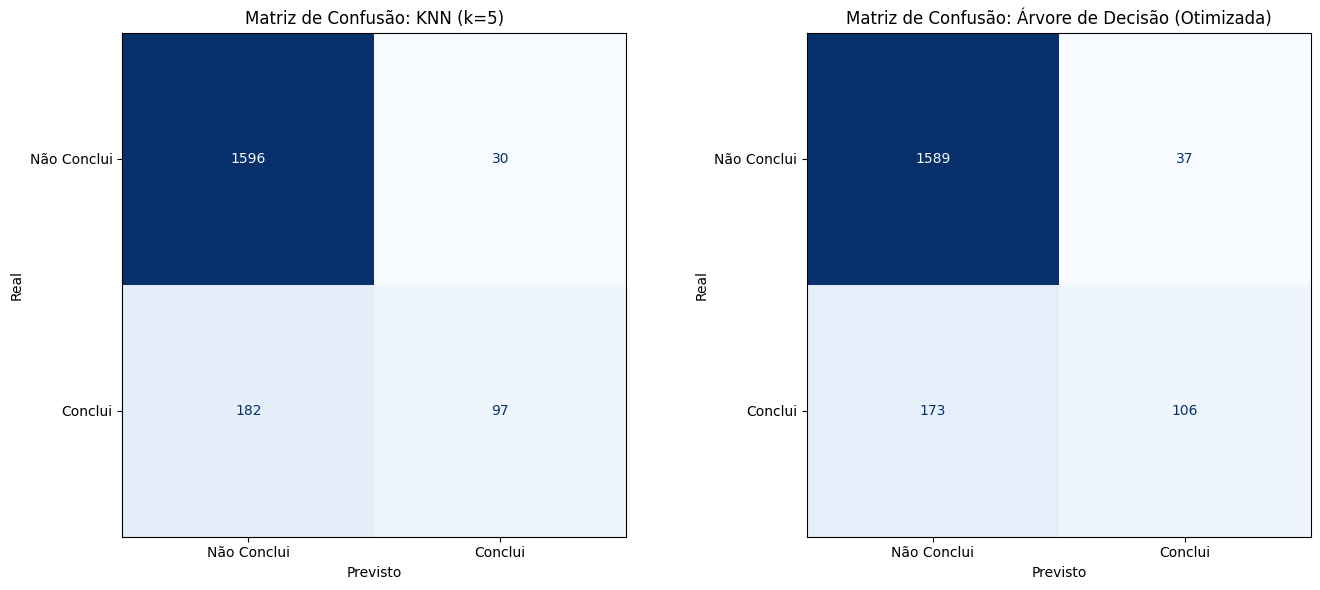

In [ ]:
# Calcular as matrizes de confusão
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0, 1])
cm_dt = confusion_matrix(y_test, y_pred_dt_final, labels=[0, 1])

# Criar os objetos ConfusionMatrixDisplay
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Não Conclui', 'Conclui'])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Não Conclui', 'Conclui'])

# Configurar a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1 linha, 2 colunas para os gráficos

# Plotar a matriz de confusão do KNN
axes[0].set_title('Matriz de Confusão: KNN (k=5)')
disp_knn.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')


# Plotar a matriz de confusão da Árvore de Decisão
axes[1].set_title('Matriz de Confusão: Árvore de Decisão (Otimizada)')
disp_dt.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')


plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

### Análise Comparativa das Matrizes de Confusão: KNN vs. Árvore de Decisão

As duas matrizes de confusão lado a lado oferecem uma visão detalhada do desempenho de cada modelo (KNN e Árvore de Decisão) no conjunto de teste, com foco em seus acertos e erros específicos para as classes "Não Conclui" e "Conclui".


Acurácia Geral Similar, Erros Diferentes: Ambos os modelos mostram uma alta performance na classe majoritária ("Não Conclui", com alto número de TNs). A acurácia geral é muito próxima, mas a forma como eles erram na classe minoritária difere.

<hr>

KNN é mais "Preciso" na Previsão de Conclusão (Menos Falsos Positivos):

- O KNN teve 30 FPs vs. 37 FPs da Árvore de Decisão.

<hr>

Árvore de Decisão "Captura Mais" Concluintes Reais (Menos Falsos Negativos):

- A Árvore de Decisão teve 173 FNs vs. 182 FNs do KNN.

<hr>

Isso sugere que a Árvore de Decisão é um pouco melhor em identificar os alunos que realmente concluem, o que é valioso se o objetivo é oferecer suporte proativo a esses alunos.


## Métodos Utilizados e Próximos Passos na Análise Preditiva

### Métodos Utilizados

#### Pré-processamento e Engenharia de Features

- Organização e limpeza dos dados.
- Criação da variável `razao_faltas_disciplinas`, combinando faltas e disciplinas para uma nova perspectiva.
- Aplicação do `StandardScaler` no pipeline do KNN para padronizar variáveis numéricas.

#### Modelagem e Otimização

- Algoritmos utilizados: **K-Nearest Neighbors (KNN)** e **Árvore de Decisão**.
- Otimização de hiperparâmetros com `GridSearchCV`, explorando combinações como `k`, `max_depth`, `min_samples_split` e `min_samples_leaf`.
- Uso de **Validação Cruzada Estratificada (5-fold)** para preservar a proporção entre concluintes e não concluintes.
- Métrica principal: **F1-score ponderado**, mais adequado que a acurácia em casos de desbalanceamento de classes.

#### Avaliação e Interpretabilidade

- Avaliação no conjunto de teste com **Matriz de Confusão** e **Relatório de Classificação**.
- Visualização da **Fronteira de Decisão (KNN)**.
- Interpretação da **Árvore de Decisão** (limitada a 5 níveis).

---

### 🚀 Próximos Passos

- **Explorar novos algoritmos como**: Random Forest, XGBoost, LightGBM, Redes Neurais (MLP).
- **Aplicar técnicas de balanceamento** como **SMOTE** ou **ADASYN**.
- **Criar novas features**, como:
  - Progresso acumulado (créditos concluídos / total)
  - Variação de desempenho ao longo do tempo

---
